<a href="https://colab.research.google.com/github/rjrizani/LLMs-in-Web-Scraping/blob/main/responsibleLLMTraining_extractSummit_joachimAsare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Joachim Asare, Harvard University
# Practical Demonstration of Responsible Use of Publicly Scraped Data for LLM Fine-Tuning


This script demonstrates how to responsibly use publicly scraped data to train and fine-tune LLMs.
We will cover potential risks such as PII, bias, and privacy issues, and provide mitigation strategies at each step.


# **Section 1: Data Collection**


## 1.0 Import Libraries and Dependencies


In [ ]:
!pip install transformers datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import requests
from datetime import datetime
from dateutil import rrule
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling

## 1.1 Scraping Reddit Data on mental health posts use case demo

In [ ]:
def scrape_reddit_to_df(subreddit, start_date, end_date, max_posts):
    # Convert dates to epoch timestamps
    """
    Responsible scraping considerations demonstrate here are include:.
    - Avoiding PII collection - usernames, email addresses and phone numbers in posts
    """
    start_epoch = int(datetime.strptime(start_date, '%Y%m%d').timestamp())
    end_epoch = int(datetime.strptime(end_date, '%Y%m%d').timestamp())

    posts_df_aggregate = pd.DataFrame({})
    epoch_list = [int(datetime(dt.year, dt.month, dt.day, hr, 0, 0).timestamp())
                  for dt in rrule.rrule(rrule.DAILY, dtstart=datetime.strptime(start_date, '%Y%m%d'),
                                        until=datetime.strptime(end_date, '%Y%m%d'))
                  for hr in (0, 12)]

    posts_collected = 0

    for i in range(0, len(epoch_list) - 1):
        if posts_collected >= max_posts:
            break
        start = epoch_list[i]
        end = min(epoch_list[i + 1], end_epoch)
        url = f'https://api.pullpush.io/reddit/submission/search?html_decode=True&subreddit={subreddit}&since={start}&until={end}&size=100'

        try:
            response = requests.get(url)
            if response.status_code == 200:
                json_posts = response.json()
                batch_posts = pd.DataFrame(json_posts['data'])
                posts_df_aggregate = pd.concat([posts_df_aggregate, batch_posts], ignore_index=True)
                posts_collected = len(posts_df_aggregate)
            else:
                print(f"Failed to fetch data: {response.status_code}")
        except Exception as e:
            print(f"An error occurred: {e}")
        if start >= end_epoch:
            break

    # Limit the number of posts to max_posts
    posts_df_aggregate = posts_df_aggregate.head(max_posts)
    return posts_df_aggregate


# User inputs for demonstration
subreddit = 'mentalhealth'
start_date = '20221003'  # YYYYMMDD
end_date = '20231005'    # YYYYMMDD
max_posts = 1000

# Define the filename for the CSV
csv_filename = f'{subreddit}_{start_date}_{end_date}_scraped_data.csv'

# don't have to scrape again if it's already saved
import os

if os.path.exists(csv_filename):
    print(f"Loading data from {csv_filename}")
    posts_df = pd.read_csv(csv_filename)
else:
    print("CSV file not found. Scraping data...")
    # Scrape and display sample data
    posts_df = scrape_reddit_to_df(subreddit, start_date, end_date, max_posts)
    posts_df.head()

    # Save the scraped data to a CSV file
    posts_df.to_csv(csv_filename, index=False)
    print(f"Data saved to {csv_filename}")


CSV file not found. Scraping data...
Data saved to mentalhealth_20221003_20231005_scraped_data.csv


#Traditional cleaning of posts (removing deleted posts in this case)

In [ ]:
def clean_posts(df):
    # Remove posts where 'selftext' is '[removed]', '[deleted]', or empty
    cleaned_df = df[
        ~(df['selftext'].isin(['[removed]', '[deleted]']) | df['selftext'].isna() | df['selftext'].str.strip().eq(''))
    ]

    # Remove posts where 'title' is empty (optional)
    cleaned_df = cleaned_df[~(cleaned_df['title'].isna() | cleaned_df['title'].str.strip().eq(''))]

    cleaned_df = df[~(df['author'].isin(['[removed]', '[deleted]']) | df['author'].isna() | df['selftext'].str.strip().eq(''))]
    # Reset index after filtering
    cleaned_df = cleaned_df.reset_index(drop=True)

    return cleaned_df

# Apply the clean_posts function to the DataFrame (assuming 'posts_df' contains your data)
posts_df_cleaned = clean_posts(posts_df)
csv_filename = f'unanonymized_data.csv'
posts_df_cleaned.to_csv(csv_filename, index=False)

# Display a sample of the cleaned DataFrame
# Display a sample of the original data to showcase PII (e.g., author usernames and content)
print("Original Data Sample (Before Anonymization):")
print(posts_df_cleaned.head())


Original Data Sample (Before Anonymization):
  all_awardings  allow_live_comments  archived                author  \
0            []                False     False  Maleficent-Vanilla21   
1            []                False     False      Lost_Sasquatch91   
2            []                False     False              bakedrat   
3            []                False     False          TheVeganVamp   
4            []                False     False             gabel0287   

   author_created_utc author_flair_background_color author_flair_css_class  \
0        1.622314e+09                          None                   None   
1        1.664194e+09                          None                   None   
2        1.561885e+09                          None                   None   
3        1.653315e+09                          None                   None   
4        1.531696e+09                          None                   None   

  author_flair_template_id author_flair_text author_f

In [ ]:
# Display a sample of the original data to showcase PII (e.g., author usernames and content)

print(posts_df_cleaned[['author', 'selftext']].head(), "\n")

                 author                                           selftext
0  Maleficent-Vanilla21  Google gives no answers and I really don't und...
1      Lost_Sasquatch91  Having the nastiest panic attacks like clockwo...
2              bakedrat  Recently I’ve been going through a rather deep...
3          TheVeganVamp  Me and my parents along with my cousin and his...
4             gabel0287                                          [removed] 



# 1.2 **Mitigation Strategy**: Limiting data collection and ensuring analysis of data for PII before use.
PII such as usernames, email addresses, and phone numbers are removed to maintain privacy.


In [ ]:
# Define a function to anonymize the data
def anonymize_data(df):
    # Remove usernames
    df['author'] = 'REDACTED'

    # Remove or redact sensitive content in 'selftext' column using regular expressions
    # Example: Remove email addresses, phone numbers, etc.
    df['selftext'] = df['selftext'].replace(
        r'[\w\.-]+@[\w\.-]+|\b\d{10,}\b',  # Regex for email addresses and phone numbers
        'REDACTED',
        regex=True
    )

    # Optionally, redact URLs in 'selftext' or 'url_overridden_by_dest'
    df['selftext'] = df['selftext'].replace(
        r'http\S+|www\.\S+',
        'REDACTED',
        regex=True
    )

    return df

# Apply the anonymization function to the scraped data
anonymized_data_df = anonymize_data(posts_df_cleaned)

# Display a sample of the anonymized data
print("Anonymized Data Sample (After Anonymization):")
print(anonymized_data_df[['author', 'selftext']].head())

# Save the anonymized data to a CSV file
anonymized_data_df.to_csv('anonymized_data.csv', index=False)
print("Anonymized data saved to 'anonymized_data.csv'.")


Anonymized Data Sample (After Anonymization):
     author                                           selftext
0  REDACTED  Google gives no answers and I really don't und...
1  REDACTED  Having the nastiest panic attacks like clockwo...
2  REDACTED  Recently I’ve been going through a rather deep...
3  REDACTED  Me and my parents along with my cousin and his...
4  REDACTED                                          [removed]
Anonymized data saved to 'anonymized_data.csv'.


# **1.3 Data Exploration and Bias Detection**


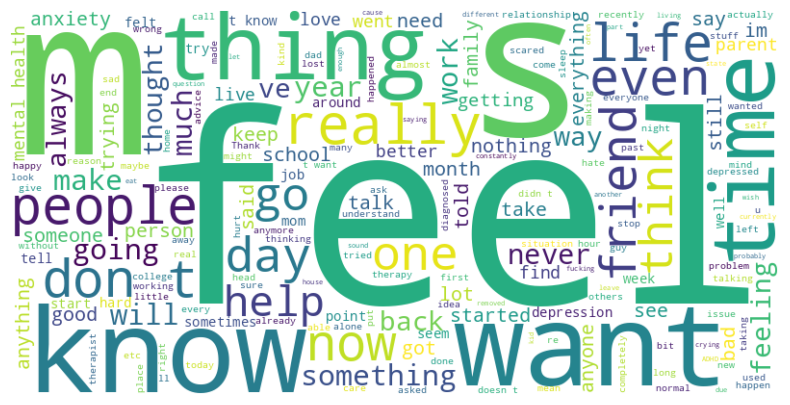

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def generate_wordcloud(df):
    """
    Generates a word cloud to visualize dominant terms in the data.
    """
    all_text = ' '.join(df['selftext'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate a word cloud to identify potential biases
generate_wordcloud(anonymized_data_df)

# **Explanation**: A word cloud helps identify dominant terms, which can indicate bias.

### The cell focuses on nouns and pronouns to analyze potential biases, especially demographic-related terms.


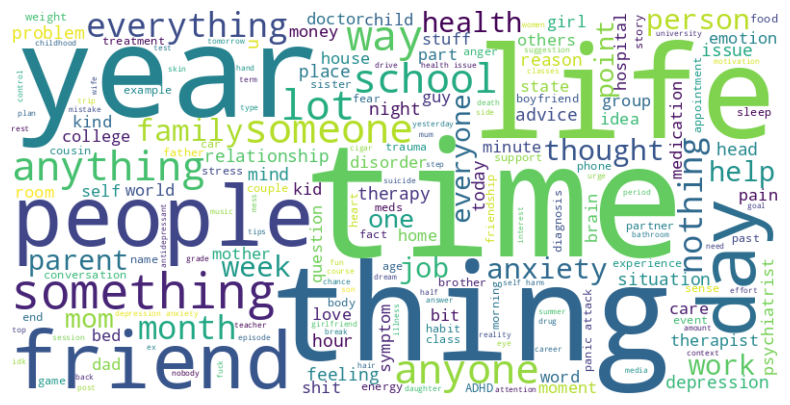

In [ ]:

import spacy

# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm')

def extract_relevant_words(text):
    """
    Extract nouns, pronouns, and relevant words from the text.
    """
    doc = nlp(text)
    relevant_words = [token.text for token in doc if token.pos_ in ['NOUN', 'PRON']]
    return ' '.join(relevant_words)

def generate_wordcloud(df):
    """
    Generates a word cloud to visualize dominant terms focused on nouns, pronouns, and relevant words.
    """
    # Concatenate all text from the dataset
    all_text = ' '.join(df['selftext'].dropna())

    # Extract relevant words (nouns, pronouns, etc.)
    filtered_text = extract_relevant_words(all_text)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate a word cloud to identify potential demographic biases
generate_wordcloud(anonymized_data_df)




# **Section 2: Training/Fine-Tuning**


In [ ]:
# Step 2: Fine-tune the LLM
# Fine-tune the LLM
def fine_tune_llm(cleaned_filename):
    # Load the cleaned CSV file into a DataFrame
    df = pd.read_csv(cleaned_filename)

    # Combine relevant text fields for fine-tuning
    df['text'] = df['title'].fillna('') + '\n\n' + df['selftext'].fillna('')

    # Convert to a Hugging Face Dataset object
    dataset = Dataset.from_pandas(df[['text']])

    # Load the pre-trained GPT-2 model and tokenizer
    model_name = 'gpt2'
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)

    # Add padding token to the tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    # Tokenize the dataset
    def tokenize_function(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    # Data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        overwrite_output_dir=True,
        num_train_epochs=3, # Train model (limiting epochs to reduce overfitting)
        per_device_train_batch_size=4,
        save_steps=500,
        save_total_limit=2,
        logging_dir='./logs',
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=tokenized_dataset,
    )

    # Fine-tune the model
    trainer.train()

    # Save the fine-tuned model
    model.save_pretrained('./fine_tuned_gpt2_mental_health')
    tokenizer.save_pretrained('./fine_tuned_gpt2_mental_health')

    print("Model fine-tuning complete and saved!")


In [ ]:
fine_tune_llm('anonymized_data.csv')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

Step,Training Loss


Model fine-tuning complete and saved!


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load the fine-tuned model and tokenizer
model_name = './fine_tuned_gpt2_mental_health'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set the pad token
tokenizer.pad_token = tokenizer.eos_token

# Function to generate response based on user input
def generate_response(prompt):
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_length=200,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            #do_sample=True,
            top_p=0.95,
            top_k=50,
            temperature=0.95,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Interactive loop to ask questions
while True:
    prompt = input("Enter a question about mental health (or type 'exit' to quit): ")
    if prompt.lower() == 'exit':
        break
    response = generate_response(prompt)
    print(f"Response: {response}\n")


Enter a question about mental health (or type 'exit' to quit): What are tips for better mental health?


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Response: What are tips for better mental health?

I’m a young woman who”s been struggling with depression for years. I“ve been diagnosed with bipolar disorder and anxiety disorder. My parents divorced when I was 12 and I have been living with my parents for the past year. 
My parents have a very supportive family and have helped me through a lot of difficult times. They have also helped with a few things I don—t want to talk about.
They have given me a ton of advice and advice on how to cope with the stress and depression. However, I feel like I need to start taking some of these things seriously. For example, my mom․s advice is to not take antidepressants. She„s also been very helpful in helping me with some things. But I also feel that I should start doing some research into the mental illness. It‘s not like she‥s a doctor, but she has a good

Enter a question about mental health (or type 'exit' to quit): How can I avoid suicide?
Response: How can I avoid suicide?

I'm not sure if I

**Mitigation Strategy**: Limit epochs to avoid model overfitting and memorization of sensitive information.


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Loading the fine-tuned model and tokenizer
model_name = './fine_tuned_gpt2_mental_health'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set the pad token
tokenizer.pad_token = tokenizer.eos_token

# Function to generate response based on user input
def generate_response(prompt):
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_length=200,
            num_return_sequences=1,
            do_sample=True,
            top_p=0.95,
            top_k=50,
            temperature=0.9,
            pad_token_id=tokenizer.eos_token_id,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Interactive loop to ask questions
while True:
    prompt = input("Enter a question about mental health (or type 'exit' to quit): ")
    if prompt.lower() == 'exit':
        break
    response = generate_response(prompt)
    print(f"Response: {response}\n")


Enter a question about mental health (or type 'exit' to quit): What are tips for better mental health?
Response: What are tips for better mental health?

I am currently in a mental health treatment session where I am focusing primarily on what I like to call'mental health' rather than just basic mental health. I don't think it is necessary and I am not trying to change anything. In fact, I have noticed that lately I feel better and have a better relationship with myself and with my life. 

I want to share some tips for better mental health as I am currently in a treatment session. Please don't just assume that I am doing something wrong and will stop until something works out. Please don't try to convince me to do this myself but ask yourself what I can do. I know that I am doing everything perfectly, in every aspect of my life.

First, I am aware that if I don't do something then the therapy might not work because it would take forever to do. Second, I am aware that sometimes the ther

In [ ]:
# Step 2: Fine-tune the LLM
# Fine-tune the LLM
def fine_tune_llm_unanonymized(cleaned_filename):
    # Load the cleaned CSV file into a DataFrame
    df = pd.read_csv(cleaned_filename)

    # Combine relevant text fields for fine-tuning
    df['text'] = df['author'].fillna('') + ': ' + df['title'].fillna('') + '\n\n' + df['selftext'].fillna('')

    # Convert to a Hugging Face Dataset object
    dataset = Dataset.from_pandas(df[['text']])

    # Load the pre-trained GPT-2 model and tokenizer
    model_name = 'gpt2'
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)

    # Add padding token to the tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    # Tokenize the dataset
    def tokenize_function(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    # Data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        overwrite_output_dir=True,
        num_train_epochs=3, # Train model (limiting epochs to reduce overfitting)
        per_device_train_batch_size=4,
        save_steps=500,
        save_total_limit=2,
        logging_dir='./logs',
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=tokenized_dataset,
    )

    # Fine-tune the model
    trainer.train()

    # Save the fine-tuned model
    model.save_pretrained('./fine_tuned_gpt2_mental_health_unanonymized')
    tokenizer.save_pretrained('./fine_tuned_gpt2_mental_health_unanonymized')

    print("Model fine-tuning complete and saved!")


In [ ]:
# Fine-tune the model with the unanonymized dataset
fine_tune_llm_unanonymized('unanonymized_data.csv')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/612 [00:00<?, ? examples/s]

Step,Training Loss


Model fine-tuning complete and saved!


In [ ]:
# Generate response with the fine-tuned model
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the fine-tuned model and tokenizer
model_name = './fine_tuned_gpt2_mental_health_unanonymized'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set the pad token
tokenizer.pad_token = tokenizer.eos_token

# Function to generate a response based on user input
def generate_response(prompt):
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_length=200,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            top_p=0.95,
            top_k=50,
            temperature=0.95,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Interactive loop to ask questions
while True:
    prompt = input("Enter a question about mental health (or type 'exit' to quit): ")
    if prompt.lower() == 'exit':
        break
    response = generate_response(prompt)
    print(f"Response: {response}\n")

Enter a question about mental health (or type 'exit' to quit): What are tips for better mental health?


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Response: What are tips for better mental health?

I’m a young woman who has been diagnosed with depression and anxiety. I”ve been struggling with my mental illness for years. My parents divorced when I was 12 and I have been living with them ever since. 
My parents have divorced and my father has left. They divorced in 2014 and have a son named Ryan. He is now a full time student at the University of Texas.
The reason I am struggling is because my parents are divorced. The reason why I feel so alone is that I don“t have any friends. When I go to school, I always feel alone. It�s because I can„t go anywhere. Even when my friends are around, they don't know where I live. So I try to go out and meet people. But I never do. And I know that my mom and dad are not going to help me. She is the one who helped me get through

Enter a question about mental health (or type 'exit' to quit): who is depressed?
Response: who is depressed?

I’m depressed. I”m not sure what to do. 
My parents are divo

#Section 3: Deployment Stage
Implementing Safety and Mitigating inherent bias further

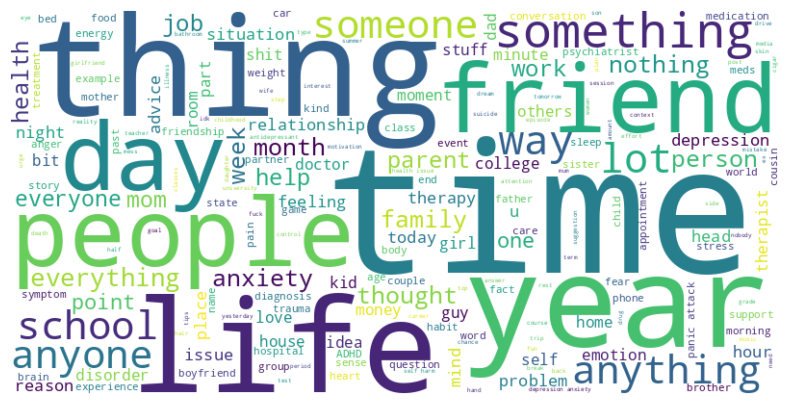

In [ ]:
generate_wordcloud(anonymized_data_df)

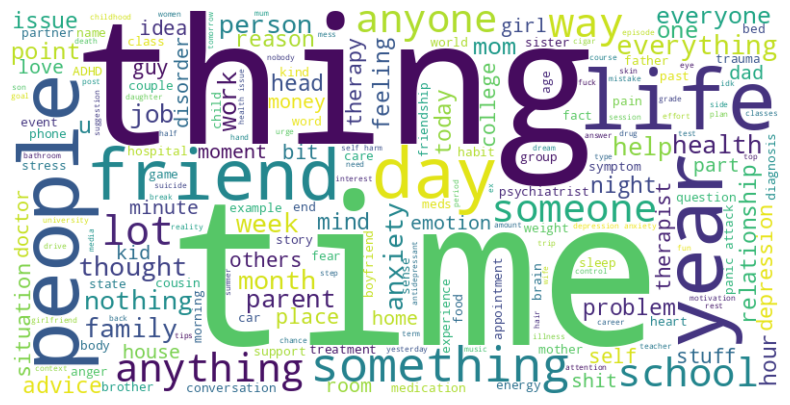

In [ ]:
generate_wordcloud(posts_df_cleaned)

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from sklearn.utils import resample
import pandas as pd
from datasets import Dataset

# Mitigation strategy for anonymized data: Ensure balanced representation
def mitigate_bias_anonymized(df):
    keywords = ['young woman', 'middle-aged man', 'teen', 'adult', 'senior']

    filtered_dfs = []
    for keyword in keywords:
        filtered_df = df[df['selftext'].str.contains(keyword, case=False, na=False)]
        if len(filtered_df) > 0:
            filtered_dfs.append(resample(filtered_df, replace=True, n_samples=100, random_state=42))

    balanced_df = pd.concat(filtered_dfs, ignore_index=True)

    if balanced_df.empty:
        print("No demographic keywords found for re-sampling in anonymized data.")
        return df

    return balanced_df

def tokenize_function(examples):
    return tokenizer(examples['selftext'], truncation=True, padding='max_length', max_length=512)

# Apply mitigation strategy on anonymized data
mitigated_anonymized_data_df = mitigate_bias_anonymized(anonymized_data_df)

# Convert the mitigated dataframe to a Hugging Face dataset
tokenized_mitigated_anonymized_dataset = Dataset.from_pandas(mitigated_anonymized_data_df[['selftext']])
tokenized_mitigated_anonymized_dataset = tokenized_mitigated_anonymized_dataset.map(tokenize_function, batched=True)

# Load the pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Add padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,  # Number of epochs
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=2,
    logging_dir='./logs',
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_mitigated_anonymized_dataset,
)

# Fine-tune the model
trainer.train()

print("Model fine-tuned with mitigated anonymized data.")


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Step,Training Loss


Model fine-tuned with mitigated anonymized data.


In [ ]:
# Test the model with prompts
prompts = ["How can I manage stress?", "What are tips for better mental health?"]
for prompt in prompts:
    response = generate_response(prompt)
    print(f"Prompt: {prompt}")
    print(f"Response: {response}\n")

Prompt: How can I manage stress?
Response: How can I manage stress?

Life for me goes like this: Wake up when my boyfriend wakes up to get my daughter ready for daycare while also feeding our three month old baby(Boyfriend feeds too and we usually pop a blanket out if our hands are too full). Change some diapers, send diapers wipes and clothes nearly every day of the week because we’re pretty sure they”re using our stuff on other babies. Maybe argue with my friend why do I do it this way? She'll tell me we both slept all of six hours the night before. Fine. Then we pop our babies out of bed and get dressed. We“re both super excited about picking up after our little ones, so why not celebrate? Not only is it just gross, but it‡s embarrassing. 
I would say we probably should just get professional and do something nice like blanketless babies†s or playing fetch„ with our iPhones. Or maybe argue

Prompt: What are tips for better mental health?
Response: What are tips for better mental heal